In [9]:
 # visualize_train
import matplotlib.pyplot as plt
from matplotlib.table import Table
import numpy as np
import matplotlib

ACTION_SYMBOLS = {0:'←', 1:'→', 2:'↑', 3:'↓'}

def draw_value_image(iteration, value_image, env):
    fig, ax = plt.subplots()
    plt.suptitle('Policy Evaluation: Iteration:{:d}'.format(iteration))
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = value_image.shape
    height, width = 1.0 / nrows, 1.0 / ncols

    # Add cells
    for (i, j), val in np.ndenumerate(value_image):
        if env.is_terminal([i, j]):
            tb.add_cell(i, j, height, width, text=' ',
                        loc='center', facecolor='white')
        elif env.is_on_obstacle([i, j]):
            tb.add_cell(i, j, height, width, text='╳',
                        loc='center', facecolor='white')
        else:
            tb.add_cell(i, j, height, width, text=val,
                        loc='center', facecolor='white')

    # Row and column labels...
    for i in range(nrows):
        tb.add_cell(i, -1, height, width, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
    for i in range(ncols):
        tb.add_cell(nrows, i, height, width/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    ax.add_table(tb)
    plt.show()



def draw_policy_image(iteration, policy_image, env):
    fig, ax = plt.subplots()
    plt.suptitle('Policy Improvement: Iteration:{:d}'.format(iteration))
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols, nactinos = policy_image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for i in range(nrows):
        for j in range(ncols):
            if env.is_terminal([i, j]):
                tb.add_cell(i, j, height, width, text=' ',
                        loc='center', facecolor='white')
            elif env.is_on_obstacle([i, j]):
                tb.add_cell(i, j, height, width, text='╳',
                        loc='center', facecolor='white')
            else:
                actions = (np.where(policy_image[i,j,:] != 0)[0]).tolist()
                actions_text = ''.join(ACTION_SYMBOLS[x] for x in actions)
                tb.add_cell(i, j, height, width, text=actions_text,
                        loc='center', facecolor='white')

    # Row and column labels...
    for i in range(nrows):
        tb.add_cell(i, -1, height, width, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
    for i in range(ncols):
        tb.add_cell(nrows, i, height, width/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')
    ax.add_table(tb)

    plt.show()





In [95]:
# agent
values = 0
policy = 0

ACTIONS = [np.array([0, -1]),
           np.array([0, 1]),
           np.array([-1, 0]),
           np.array([1, 0])]


class AGENT:
    def __init__(self, env, is_upload=False):

        self.ACTIONS = ACTIONS
        self.env = env
        HEIGHT, WIDTH = env.size()
        self.state = [0,0]

        if is_upload:
            self.values = values
            self.policy = policy
        else:
            self.values = np.zeros((HEIGHT, WIDTH))
            self.policy = np.zeros((HEIGHT, WIDTH,len(self.ACTIONS)))+1./len(self.ACTIONS)


    def policy_evaluation(self, iter, env, policy, discount=1.0):
        HEIGHT, WIDTH = env.size()
        new_state_values = np.zeros((HEIGHT, WIDTH))
        iteration = 0

        ###
        # run loop until delta < 0.0001
        while 1:
          # increase iteration count
          iteration += 1
          # set v(s) = sum of p(policy) * (r + discount * next_state_values)
          state_values = new_state_values
          # store previous v(s) (not updated)
          temp = state_values.copy()

          # evaluate value for every grid without terminal and obstacle case
          for i in range(HEIGHT):
            for j in range(WIDTH):
              if not env.is_terminal([i, j]) and not env.is_on_obstacle([i, j]):
                sum = 0
                # get values for every action at the grid
                for action_idx, direction in enumerate(ACTIONS):
                  (next_i, next_j), reward = env.interaction([i, j], direction)
                  sum += policy[i, j, action_idx] * (reward + discount * state_values[next_i, next_j])
                # update new state values
                new_state_values[i, j] = sum
          
          # stop running when changing gap between prev value and new value is small enough
          if abs(temp - new_state_values).max() < 0.0001:
            break
        ###

        draw_value_image(iter, np.round(new_state_values, decimals=2), env=env)
        return new_state_values, iteration


    def policy_improvement(self, iter, env, state_values, old_policy, discount=1.0):
        HEIGHT, WIDTH = env.size()
        policy = old_policy.copy()

        ###
        # evaluate value for every grid without terminal and obstacle case
        for i in range(HEIGHT):
          for j in range(WIDTH):
            if not env.is_terminal([i, j]) and not env.is_on_obstacle([i, j]):
              action_values = []
              # calculate action_values by each actions
              for direction in ACTIONS:
                (next_i, next_j), reward = env.interaction([i, j], direction)
                action_values.append((reward + discount * state_values[next_i, next_j]))

              new_actions = np.zeros(4)
              action_idx = []
              # choose new policy by calculating max action value
              for value in action_values:
                if value == np.amax(action_values):
                  action_idx.append(True)
                else:
                  action_idx.append(False)

              # set positive value for new actions, 0 for not choosen actions
              for idx, val in enumerate(action_idx):
                if val == 1:
                  new_actions[idx] = 1 / np.sum(action_idx)
                else:
                  new_actions[idx] = 0
              policy[i, j, :] = new_actions

        # if delta is small enough, stop improvement
        delta = abs(old_policy - policy).sum()
        if delta < 0.0001:
          policy_stable = True
        else:
          policy_stable = False
        ###

        print('policy stable {}:'.format(policy_stable))
        draw_policy_image(iter, np.round(policy, decimals=2), env=env)
        return policy, policy_stable



    def policy_iteration(self):
        iter = 1
        while (True):
            self.values, iteration = self.policy_evaluation(iter, env=self.env, policy=self.policy)
            self.policy, policy_stable = self.policy_improvement(iter, env=self.env, state_values=self.values,
                                                       old_policy=self.policy, discount=1.0)
            iter += 1
            if policy_stable == True:
                break
        return self.values, self.policy



    def get_action(self, state):
        i,j = state
        return np.random.choice(len(ACTIONS), 1, p=self.policy[i,j,:].tolist()).item()


    def get_state(self):
        return self.state

In [96]:
# environment

class grid_world:

    def __init__(self, HEIGHT, WIDTH, GOAL, OBSTACLES):
        self.height = HEIGHT
        self.width = WIDTH
        self.goal = GOAL
        self.obstacles = OBSTACLES

    def is_terminal(self, state):   # Gaol state
        return state in self.goal

    def is_out_of_boundary(self, state):
        x, y = state
        if x < 0 or x >= self.height or y < 0 or y >= self.width:
            return True
        else:
            return False

    def is_on_obstacle(self, state):
        if state in self.obstacles:
            return True
        else:
            return False

    def reward(self, state, action, next_state):
        if self.is_terminal(state):
            return 0
        else:
            return -1

    def interaction(self, state, action):
        if self.is_terminal(state):
            next_state = state
        else:
            next_state = (np.array(state) + action).tolist()

        if self.is_out_of_boundary(next_state):
            next_state = state

        if self.is_on_obstacle(next_state):
            next_state = state

        r = self.reward(state,action,next_state)
        return next_state, r

    def size(self):
        return self.height, self.width


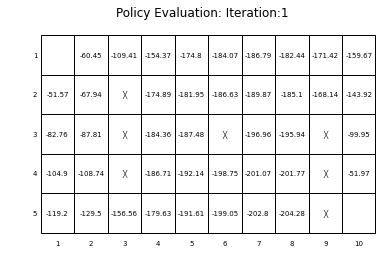

policy stable False:


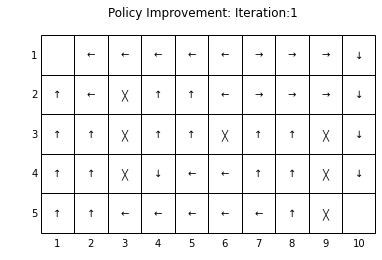

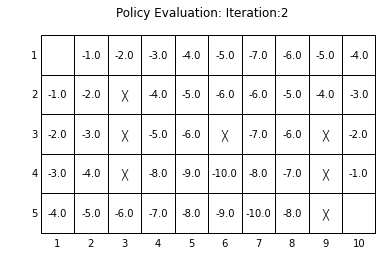

policy stable False:


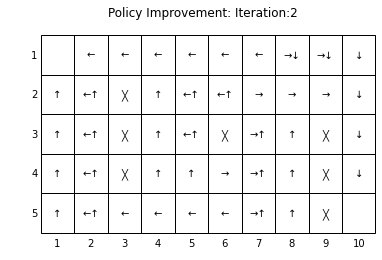

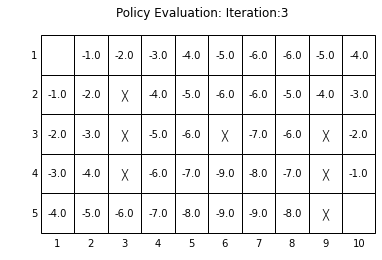

policy stable False:


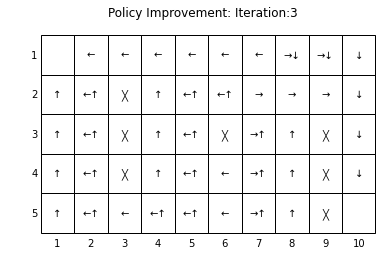

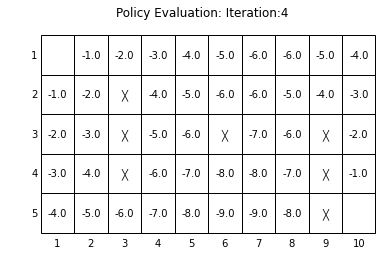

policy stable False:


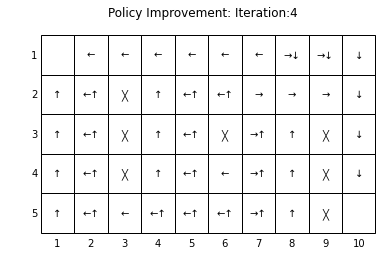

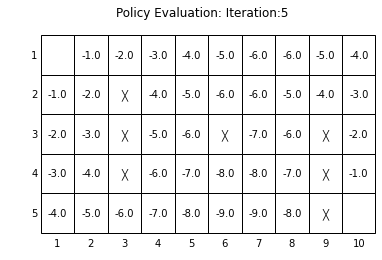

policy stable True:


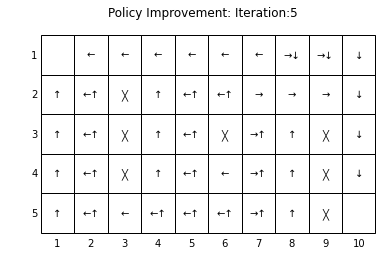

In [97]:
# main_train

WORLD_HEIGHT = 5
WORLD_WIDTH = 10

env = grid_world(WORLD_HEIGHT,WORLD_WIDTH,
                 GOAL = [[0,0], [WORLD_HEIGHT-1, WORLD_WIDTH-1]],
                 OBSTACLES= [[2,5], [1,2], [2,2], [3,2], [2, 8],[3, 8],[4, 8]])
agent = AGENT(env,is_upload=False)
values, policy = agent.policy_iteration()